# Problemy do rozwiązania

# 1. Imports

In [25]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import sqrt
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import *
from rdkit.DataStructs import DiceSimilarity
from rdkit.DataStructs.cDataStructs import CreateFromBitString

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

---

# 2. Functions

## Transform numpy array into RDKit ExplicitBitVect

In [28]:
def CreateFromBinaryArray(arr):
    '''
    RDKit ExplicitBitVect data structure automatically converts into an array if stored in a numpy array.
    This function restores the RDKit structure for the sake of calculating similarity with the DiceSimilarity()
    function, which accepts only RDKit structures as input and returns an error on numpy arrays.
    '''
    s = ''.join([str(x) for x in arr])
    return CreateFromBitString(s)

## Preparing the dataset

#### Reading smiles of molecules from .ism files

In [2]:
def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    mol_list = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        mol_list.append(smile)
    return mol_list

#### Creating molecule representations

In [24]:
def get_class_vectors(mol_matrix, rType = 'fingerprint', f_size=2048):
    '''
    For each molecule in the array (list of lists):
    create its representation for training (ingerprint/descriptor/mixed)
    and a binary vector showing which classes it belongs to.
    Fingerprint will be of size = f_size.
    '''
    cv_dict = {}
    for i,l in enumerate(mol_matrix):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol, f_size)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else:
                    rep = descriptor(mol) + list(fingerprint(mol, f_size))
                
                labels = [0]*len(mol_matrix)
                cv_dict[smile] = [rep, labels]
            cv_dict[smile][1][i] = 1
    # Normalize descriptors
    if rType != 'fingerprint':
        matrix_to_norm = []
        for vals in cv_dict.values():
            matrix_to_norm.append(vals[0][:37]) #there are 37 descriptors
        matrix_to_norm = np.array(matrix_to_norm)
        v_min = matrix_to_norm.min(axis=0)
        v_max = matrix_to_norm.max(axis=0) - v_min
        for key in cv_dict.keys():
            for i in range(37):
                normed_val = (cv_dict[key][0][i] - v_min[i]) / v_max[i]
                cv_dict[key][0][i] = normed_val
    return cv_dict

def fingerprint(mol, f_size=2048):
    return GetMorganFingerprintAsBitVect(mol,2,f_size)

def descriptor(mol):
    functions = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for function in functions:
        descriptors.append(function(mol))
    return descriptors

#### Separating singletons

In [4]:
def separate_singular_uniques(fingerprints, labels):
    '''
    Separate examples with unique labels which appear only once.
    This is done to ensure proper functionality of *train_test_split()*
    when using the *stratify* argument.
    '''
    # Find indices of singular uniques
    unique_labels, unique_indices, unique_counts = np.unique(
        ar=labels, return_index=True, return_counts=True, axis=0)
    singular_indices = unique_indices[unique_counts==1]
    # Separate fingerprints
    fingerprints_no_singular = np.delete(fingerprints, singular_indices, axis=0)
    fingerprints_only_singular = fingerprints[singular_indices]
    # Separate labels
    labels_no_singular = np.delete(labels, singular_indices, axis=0)
    labels_only_singular = labels[singular_indices]
    
    return fingerprints_no_singular, labels_no_singular, fingerprints_only_singular, labels_only_singular

In [41]:
def split_singular(fingerprints, labels, test_size=0.2, random_state=15):
    '''
    Split examples with unique labels which appear only once into training and validation sets.
    Calculate dice similarity between examples.
    Highly simmilar examples will all be allocated into the training set.
    The rest of examples will be split by train_test_split() function from sklearn.
    '''
    # Restore ooriginal RDKit structure of fingerprints
    fps_tmp = [CreateFromBinaryArray(x) for x in fingerprints]
    
    # Create a similarity matrix
    r = len(fps_tmp)
    similarity_matrix = np.zeros([r, r])
    for i in range(r):
        for j in range(i+1, r):
            similarity_matrix[i,j] = similarity_matrix[j,i] = DiceSimilarity(fps_tmp[i], fps_tmp[j])
    
    # Acquire the indices of highly similar examples
    highly_similar_indices = np.where(0.75<=similarity_matrix)
    highly_similar_indices = np.unique(highly_similar_indices[0])
    
    # Separate highly similar examples from the rest
    hs_f = fingerprints[highly_similar_indices]
    hs_l = labels[highly_similar_indices]
    other_f = np.delete(fingerprints, highly_similar_indices, axis=0)
    other_l = np.delete(labels, highly_similar_indices, axis=0)
    
    # Split the rest into training and validation sets
    train_f, test_f, train_l, test_l = train_test_split(other_f, other_l, test_size=test_size, random_state=random_state)
    
    # Append the highly similar examples to the training set
    train_f = np.append(train_f, hs_f, axis=0)
    train_l = np.append(train_l, hs_l, axis=0)
    
    return train_f, test_f, train_l, test_l

#### Creating training and validation sets

In [37]:
# molecules <--- mol_matrix
def prepare_sets(molecules, val_prc=0.2, rType='fingerprint', f_size=2048):
    '''
    Create training and validation sets with labels from an array of smiles
    rType - type of representation - fingerprint/descriptor/mixed
    f_size - size of the fingerprint if rType is fingerprint or mixed
    '''
    '''# Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,'fingerprint',1024)'''

    # Split the data into training and validation sets
    fingerprints, labels = [],[]
    for val in molecules.values():
        fingerprints.append(val[0]) # [fingerprint]
        labels.append(val[1]) # [label]
    fingerprints = np.array(fingerprints)
    labels = np.array(labels)
    
    # separating and splitting singletons
    fns,lns,fos,los = separate_singular_uniques(fingerprints,labels)
    only_singular = split_singular(fos, los, test_size=0.2, random_state=15)
    
    # splitting the rest of the data
    no_singular = train_test_split(fns, lns, test_size=0.2, random_state=15, stratify=lns)
    

    # Training set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    train_mols = np.append(no_singular[0], only_singular[0], axis=0)
    train_labels = np.append(no_singular[2], only_singular[2], axis=0)
    # Validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols = np.append(no_singular[1], only_singular[1], axis=0)
    val_labels = np.append(no_singular[3], only_singular[3], axis=0)
    
    return train_mols, val_mols, train_labels, val_labels

In [34]:
%%time
rep_dict = get_class_vectors(mol_matrix, rType, f_size)

CPU times: user 30.4 s, sys: 16 ms, total: 30.4 s
Wall time: 30.4 s


In [40]:
%%time
train_mols,val_mols,train_labels,val_labels = prepare_sets(rep_dict, val_prc, rType, f_size)

(231,)
other_f:	 (275, 1024)
other_l:	 (275, 73)
CPU times: user 2min 28s, sys: 2.25 s, total: 2min 30s
Wall time: 2min 30s


## Neuron layers

In [6]:
def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.relu(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=2048):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0: # Input Layer
            w,b,h = neuron_layer(isize, layers[0], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    
    return active_layers

## Training functions

In [7]:
def next_batch(mols, labels, size):
    '''
    Extracts the next batch from a dataset.
    If the dataset size is not dividable by batch size with reminder 0,
    the last full batch and the remaining incomplete batch will be merged 
    in order to incorporate all data.
    '''
    global batch_number
    start = batch_number*size
    if batch_number == len(mols)//size-1:
        #the last batch may be larger to incorporate all data
        # -1 because the first batch number is 0
        batch_number = 0
        return mols[start:], labels[start:]
    else:
        batch_number += 1
        return mols[start:start+size], labels[start:start+size]

def shuffle_data(mols, labels):
    '''Shuffles the training set after an epoch'''
    indices = list(range(len(mols)))
    random.shuffle(indices)
    new_mols = mols[indices]
    new_labels = labels[indices]
    return new_mols, new_labels

def timer(start,end):
    '''
    Calculates and formats the time since start to end.
    Used for timing the training of the network.
    Returns:
        string representation of the result
    '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

def calculate_confusion_matrix(y_true, y_pred):
    '''
    Calculates true/false positives/negatives in y_pred based on y_true
    for each class seperately.
    Returns:
        An array of shape (4, number_of_classes)
        in the following order:
            number of true positives
            number of false negatives
            number of true negatives
            number of false positives.
    '''
    num_class = len(y_true[0]) #number of classes
    tp = np.array([0] * num_class)
    fn = np.array([0] * num_class)
    tn = np.array([0] * num_class)
    fp = np.array([0] * num_class)
    for i in range(num_class):
        for j in range(len(y_true)):
            if y_pred[j][i] == y_true[j][i]:
                if y_true[j][i] == 1:
                    tp[i] += 1
                else:
                    tn[i] += 1
            else:
                if y_true[j][i] == 1:
                    fn[i] += 1
                else:
                    fp[i] += 1
    return [tp,fn,tn,fp]

In [8]:
def train_network(train_mols, train_labels, batch_size, epochs, show_progress=True, save=True):
    '''
    This function trains the network.
    A single iteration of training corresponds to a single batch,
    and the total number of iterations equals:
        total number of training samples floor-divided by batch size and multiplied by the number of epochs.
    ------
    Returns:
        the rate of training accuracy, saved every 200 training iterations
        the rate of validation accuracy, saved every 200 training iterations
        f1 score in three variants -- micro, macro, weighted -- saved every 200 training iterations
        confusion matrix.
    '''
    if show_progress:
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        start = time.time()
    if save:
        global save_location
        save_step=0
    # Variables:
    global train, val_pred, val_mols, val_labels, batch_number
    iterations = len(train_mols) // batch_size * epochs
    tr_rate = []   # training rate
    val_rate = []  # validation rate
    f1 = [[],[],[]]
    confusion_matrix = []
    batch_number = 0
    # Training:
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        if save: # Create the first checkpoint
            saver.save(session, save_location, global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            if i != 0 and batch_number == 0:
                train_mols, train_labels = shuffle_data(train_mols, train_labels)
            
            batch_mols, batch_labels = next_batch(train_mols, train_labels, batch_size)
            
            session.run(train, feed_dict={x: batch_mols, t: batch_labels})
            
            # Create a checkpoint and/or display progress
            if i == 0 or (i+1)%(iterations//10) == 0:
                if save:
                    save_step += 1
                    saver.save(session, "tmp/checkpoint", global_step = save_step)
                if show_progress:
                    progress = int((i+1)/(iterations//10))*10
                    now = timer(start,time.time())
                    print("%3i" % progress + '%, ' + str(now))                
            
            # Validate predictions
            if i % 200 == 0 or i == iterations-1:
                
                tr_target = batch_labels
                tr_predictions = session.run(predict, feed_dict={x: batch_mols, t: batch_labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                
                f1[0].append(f1_score(val_labels, val_predictions, average='micro'))
                f1[1].append(f1_score(val_labels, val_predictions, average='macro'))
                f1[2].append(f1_score(val_labels, val_predictions, average='weighted'))
        
        #Create a confusion matrix
        confusion_matrix = calculate_confusion_matrix(val_labels,val_predictions)
        # Final checkpoint and/or total time
        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step+1)
        if show_progress:
            print(timer(start,time.time()))
    return tr_rate, val_rate, f1, confusion_matrix


## Functions to draw and save plots

In [9]:
def filename_gen(plot_type='', path=''):
    ''' Generates a filename for a plot. '''
    if plot_type != '':
        plot_type += '_'
    filename = plot_type
    layers_str = "{}'{}".format(len(layers),max(layers))
    filename += "{}_{}_{}_{:>6}_{}_{}_{:.4}_{}".format(
                num_class, f_size, layers_str, learning_rate, batch_size, epochs, max(val_rate), rType)
    filename = filename.replace(".","'")
    filename = filename.replace(" ","_")
    filename = path + filename + ".pdf"
    return filename

def save_accuracy_plot(tr_rate, save=True, path="plots/"):
    '''
    Draws and saves a plot which displays changes of accuracy 
    during training for training and validation sets.
    '''
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = [i*200 for i in range(len(tr_rate))]
    ax.plot(x,tr_rate, label='trening')
    ax.plot(x,val_rate, label='walidacja')
    ax.legend(loc=5)
    ax.set_ylabel('Dokładność')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('',path)
        plt.savefig(filename);

def save_f1_plot(f1, save=True, path="plots/"):
    '''
    Draws and saves a plot which displays changes of F1-score
    during training for the validation set.
    F1 calculated and drawn in three types of averaging.
    '''
    plt.close()
    fig = plt.figure()
    x = [i*200 for i in range(len(f1[0]))]
    ax = fig.add_subplot(111)
    
    ax.plot(x,f1[0], label='F1 micro')
    ax.plot(x,f1[1], label='F1 macro')
    ax.plot(x,f1[2], label='F1 ważone')
    ax.legend(loc=7)
    ax.set_ylabel('F1')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('f1',path)
        plt.savefig(filename);

def save_confusion_matrix_plot(cm, save=True, path='plots/'):
    '''
    Draws and saves a histogram of true/false positive/negative fractions:
    True Positive rate, False Positive Rate, False Negative Rate and
    False Discovery Rate.
    True Negative Rate not included due to having values indistinguishably
    close to 100%; however, TNR = 100% - FPR, and the FPR histogram is more
    visually clear.
    '''
    plt.close()
    fig = plt.figure()
    subplots = [fig.add_subplot(221), fig.add_subplot(222),
                fig.add_subplot(223), fig.add_subplot(224)]
    titles = ['Odsetek prawdziwie pozytywnych', 'Odsetek fałszywie pozytywnych',
              'Odsetek fałszywie negatywnych', 'Odsetek fałszywych odkryć']
    rate_values = [cm[0]/(cm[0]+cm[1]), cm[3]/(cm[2]+cm[3]),
                   cm[1]/(cm[0]+cm[1]), cm[3]/(cm[0]+cm[3])]
    xlabel = 'Cele terapeutyczne'
    xrange = range(1,len(cm[0])+1)
    
    for i, ax in enumerate(subplots):
        ax.bar(xrange, rate_values[i])
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_xlim([0,num_class+2])
        vals = ax.get_yticks()
        if i == 1: #false positive rate is very small
            ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
        else:
            ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    plt.tight_layout()
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    
    if save:
        filename = filename_gen('cm',path)
        plt.savefig(filename)

---

# 3. Script

## Prepare data

### Fetch the list of names of the files that contain the data

In [10]:
'''
Get the list of filenames in data/targets/
ordered by descending size of class.
'''
with open("receptors_descending.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]

print(len(receptors))
receptors[:5]

73


[['DRD2.ism', '6229'],
 ['HTR1A.ism', '5592'],
 ['SLC6A4.ism', '5414'],
 ['OPRM1.ism', '5263'],
 ['ADORA1.ism', '4136']]

### Specify the number of classes to be used

In [11]:
'''
num_class most numerous classes will be used for further analysis.
2 <= num_class <= 73
'''
num_class = 73

assert 2 <= num_class <= 73 and type(num_class)==int, "Invalid number of classes. Choose an int value from range <2, 73>"

### Specify the path to the directory containing data files

In [12]:
ism_path = 'data/targets/'   #path to .ism files which represent classes and contain molecules

### Create a matrix of smiles belonging to each class

In [13]:
mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(ism_path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

['CN1CCN(CC1)C2=Cc3ccccc3C(=C(C)C)c4ccccc24',
 'CN1CCN(CC1)C2=Nc3cc(Cl)ccc3Nc4ccccc24',
 'CN1CCC(CC1)C2=Cc3cc(Cl)ccc3Cc4ccccc24']

### Type of representation:

#### Fingerprint

In [20]:
rType = 'fingerprint'
f_size = 1024        #size of fingerprint

#### Descriptor

#### Mixed

## Split the data into training and validation sets

### Specify the size of the validation set as percentage of the entire dataset

In [15]:
val_prc = 0.2        #the percent of all data that will be allocated into the validation set

### Split

Note: this may take a while.

In [22]:
%%time
train_mols,val_mols,train_labels,val_labels = prepare_sets(mol_matrix, val_prc, rType, f_size)

ArgumentError: Python argument types in
    rdkit.DataStructs.cDataStructs.DiceSimilarity(numpy.ndarray, numpy.ndarray)
did not match C++ signature:
    DiceSimilarity(RDKit::SparseIntVect<unsigned long> siv1, RDKit::SparseIntVect<unsigned long> siv2, bool returnDistance=False, double bounds=0.0)
    DiceSimilarity(RDKit::SparseIntVect<unsigned int> siv1, RDKit::SparseIntVect<unsigned int> siv2, bool returnDistance=False, double bounds=0.0)
    DiceSimilarity(RDKit::SparseIntVect<long> siv1, RDKit::SparseIntVect<long> siv2, bool returnDistance=False, double bounds=0.0)
    DiceSimilarity(RDKit::SparseIntVect<int> siv1, RDKit::SparseIntVect<int> siv2, bool returnDistance=False, double bounds=0.0)
    DiceSimilarity(ExplicitBitVect bv1, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > pkl, bool returnDistance=0)
    DiceSimilarity(SparseBitVect bv1, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > pkl, bool returnDistance=0)
    DiceSimilarity(ExplicitBitVect bv1, ExplicitBitVect bv2, bool returnDistance=0)
    DiceSimilarity(SparseBitVect bv1, SparseBitVect bv2, bool returnDistance=0)

## Optional - Saving and loading prepared sets

This is done to preserve time if one wishes to continue calculations on a set another time. 

In [18]:
import pickle

def load_var(name):
    with open(name,'rb') as f:
        return pickle.load(f)

def save_var(name,var):
    with open(name,'wb') as f:
        pickle.dump(var,f)

In [19]:
save_var("73_2048.txt",{"tm":train_mols,"tl":train_labels,"vm":val_mols,"vl":val_labels})

In [21]:
loaded = load_var("73_2048.txt")
train_mols=loaded["tm"]
train_labels = loaded["tl"]
val_mols=loaded["vm"]
val_labels=loaded["vl"]

##  User-defined network variables:

In [22]:
layers = [500,500]
learning_rate = 0.001
batch_size = 25
epochs = 10

## Create and train the network

### Preparing random generators and resetting tensorflow graph

In [23]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)

### Automatic network variables

In [24]:
'''
isize - size of the input layer, equal to the size of
        the data representation (fingerprint/descriptor/mixed)
osize - size of the output layer, equal to the number of classes.
'''
isize = val_mols.shape[1]
osize = num_class

### Creating neuron layers

In [25]:
active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets

### Saving checkpoints

In [26]:
'''
A function that creates checkpoints during training,
which can later be used to reconstruct the network
and use the test set with it.
Following checkpoints are created:
                before training begins
                after every 10% of progress
                after training.
That is 12 checkpoints in total.
Running the training function will overwrite existing checkpoints.
Checkpoints will be saved to save_location directory.
'''
saver = tf.train.Saver(max_to_keep=12)
save_location = "tmp/checkpoint"

### Optimizer function

In [27]:
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=t, logits=a))
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

### Prediction

In [28]:
y = tf.nn.sigmoid(a)
predict = tf.round(y)

### Batch number

In [29]:
''' Batch number is used as a global variable in the training-associated functions. '''
batch_number = 0

### Training the network

Note: you might receive a warning regarding F-score when training the network. This is expected and can be ignored.

In [41]:
tr_rate, val_rate, f1, confusion_matrix = train_network(train_mols, train_labels, batch_size, epochs, show_progress=True, save=True)

2018-09-28 16:02:07
  0%, 00:00:00


/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 10%, 00:00:10
 20%, 00:00:19
 30%, 00:00:28
 40%, 00:00:38
 50%, 00:00:47
 60%, 00:00:56
 70%, 00:01:06
 80%, 00:01:15
 90%, 00:01:24
100%, 00:01:34
00:01:38


# Accuracy

In [42]:
max(val_rate)*100

75.95371542216597

# 4. Plots for evaluating predictions, and saving results.

### Accuracy - training and validation rates

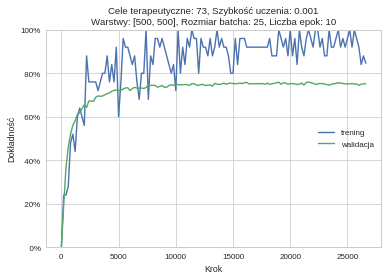

In [43]:
save_accuracy_plot(tr_rate, save=False, path='plots/')

### F1 score

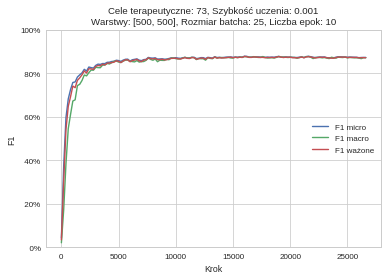

In [44]:
save_f1_plot(f1, save=False, path='plots/')

### True/false-positive/negative-related histograms

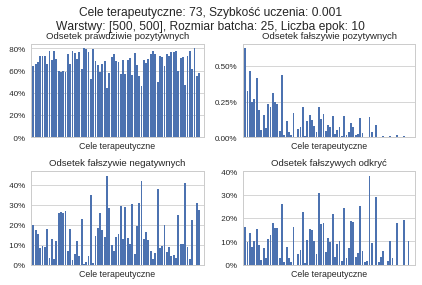

In [45]:
save_confusion_matrix_plot(confusion_matrix, save=False, path='plots/')

---

# Nie jestem pewien do czego to było, muszę sprawdzić

---

# Poniższe chwilowo nie działa, do naprawy

# 5. Testing the network on drugs

## Preparing the test set

In [46]:
with open('data/drug_targets_untrained.csv') as f: #or 'data/drug_targets.csv' for the full set
    drug_targets = [l.strip().split(',') for l in f.readlines()[1:]]
class_to_smiles = {}
for l in drug_targets:
    if l[2] not in class_to_smiles.keys():
        class_to_smiles[l[2]] = []
    class_to_smiles[l[2]].append(l[4])

targets = [l[0].strip('.ism') for l in receptors]

drug_mol_matrix = [[]]*73
for k, v in class_to_smiles.items():
    drug_mol_matrix[targets.index(k)] = v

cv_dict = get_class_vectors(drug_mol_matrix, f_size=f_size)
drug_mols, drug_labels = [], []
for v in cv_dict.values():
    drug_mols.append(v[0])
    drug_labels.append(v[1])
drug_mols, drug_labels = np.array(drug_mols), np.array(drug_labels)

## *Rebuilding the network
(if the training code in section 3. has not been run)

In [20]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)
# Automatic network variables
isize = 4096
osize = 73
active_layers = setup_layers([800,800], osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets
saver = tf.train.Saver(max_to_keep=12)
# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)

## Restoring network from checkpoint and running test data

In [48]:
f1=[[],[],[]]
with tf.Session() as sess:
    saver.restore(sess, 'tmp/checkpoint-12')
    
    drug_pred = sess.run(predict, feed_dict={x: drug_mols, t: drug_labels}) #rounded prediction values
    drug_pred_roc = sess.run(y, feed_dict={x: drug_mols, t: drug_labels}) #not-rounded, raw prediction values
    drug_rate = (drug_labels == drug_pred).mean(axis=0)
    
    f1[0].append(f1_score(drug_labels, drug_pred, average='micro'))
    f1[1].append(f1_score(drug_labels, drug_pred, average='macro'))
    f1[2].append(f1_score(drug_labels, drug_pred, average='weighted'))
    score_per_class = confusion_matrix(drug_labels,drug_pred)

ValueError: Cannot feed value of shape (180, 2048) for Tensor 'Placeholder:0', which has shape '(?, 1024)'

In [ ]:
precision_score(drug_pred,drug_labels, average="weighted")
precision_score((drug_pred_roc > 0.01).astype(float),drug_labels, average="weighted")
confusion_matrix(drug_labels, drug_pred)
[sum(i) for i in confusion_matrix]
fpr, tpr, thresholds = roc_curve(drug_labels.flatten(), drug_pred_roc.flatten())
auc(fpr,tpr)

In [ ]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Krzywa ROC (pole powierzchni = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='#4C72B0', lw=2, linestyle='--')
plt.axes().set_aspect('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakterystyka operacyjna odbiornika (ROC curve)')
plt.legend(loc="lower right")
#plt.savefig('plots/best/drugs_roc.pdf')
plt.show()

---